# Wind power direction
Compare various parametrizations:
- Fourier series
- GP using periodic kernel
- Scikit-learn using periodic kernel

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared

from python import parsers, fourrier, gaussian_algebra

## Read some data
Taken from: `https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens`, Eelde station.

Take data from nieuw beerta (station 06286) using meteostat download. It is naively assumed that the power of the wind is the wind speed times duration.

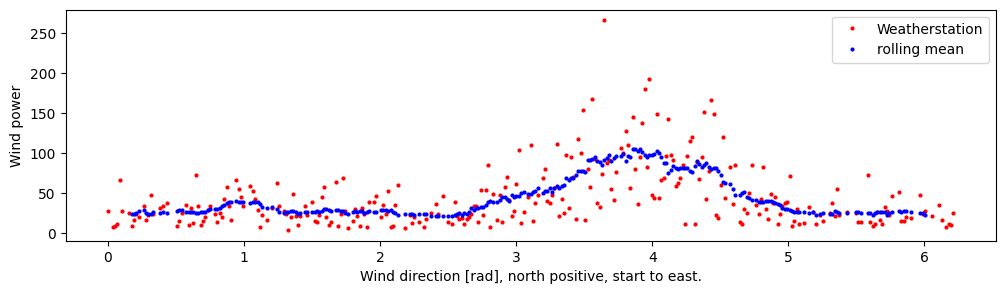

In [3]:
df = parsers.get_wind_power_per_direction("data/nieuw_beerta_weather_export.csv")

# Quick check
_, ax = plt.subplots(1,1, figsize=(12,3))
ax.plot(df.index, df.wspd, linestyle='none', marker='o', markersize=2, color='red', label='Weatherstation')
ax.plot(df.index, df.wspd_rolling_mean, linestyle='none', marker='o', markersize=2, color='blue', label='rolling mean')
ax.set_ylabel('Wind power')
ax.set_xlabel('Wind direction [rad], north positive, start to east.')
ax.legend()

### Fourier approximation
Many texts describe the well-known fourier approximations. I particularly found 
https://math.mit.edu/~gs/cse/websections/cse41.pdf
to be clear.

$ F(x) \approx  \sum_{n=1}^{N} a_n cos\left( nx \right) + \sum_{n=1}^{N} b_n sin\left( nx \right) $

Where the coefficients can be obtained by integrating over the signal:

$ a_0 = \frac{1}{2\pi}\int_{-\pi}^{pi}F(x)dx $

$ a_k = \frac{1}{\pi}\int_{-\pi}^{pi}F(x)cos(kx) dx $

$ b_k = \frac{1}{\pi}\int_{-\pi}^{pi}F(x)sin(kx) dx $

In [4]:
a,b = fourrier.integrate_fourier_coeficients(df, K=6, n_integration_bins=360, channel='wspd')
s = fourrier.evaluate_fourier_series(df.index, a, b)

### Gaussian process approximation - Scikit

In [5]:
# GP fit
noise_std = 0.8 # Quite critical parameter
angles = df.index.values.reshape(-1, 1)
wind = df.wspd.values.reshape(-1, 1)

# kernel = 1 * RBF(length_scale=1000.0, length_scale_bounds=(1, 1e5))
kernel =  ExpSineSquared(length_scale=0.00100, length_scale_bounds=(0.0001, 100), periodicity=2*np.pi, periodicity_bounds='fixed')

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=noise_std**2)
gaussian_process.fit(angles, wind)
mean_prediction, std_prediction = gaussian_process.predict(angles, return_std=True)

df_gp = pd.DataFrame(index=df.index)
df_gp['wind'] = mean_prediction
df_gp['wind_std'] = std_prediction

### Gaussian process own kernel

In [6]:

def K_periodic(x, l=2.3):
    """Periodic on exactly 2pi"""
    delta_x = x[1]-x[0]
    num = -2*np.sin(delta_x/2)**2
    l_sq = l**2
    return np.exp(num/(l_sq))


# Define measured data and points to evaluate.
angles_measured = df.index.values
wind_measured = df.wspd.values
angles_eval = np.linspace(0, 2*np.pi, 360)

x_combined = np.concat( (angles_measured, angles_eval))

# Create covariance matrix - the lazy way.
sigma_y_sq = 0
n_combined = len(x_combined)

K_combined = sigma_y_sq*np.eye(n_combined)
for i in range(n_combined):
    for j in range(n_combined):
        x = np.asarray( [x_combined[i], x_combined[j] ])

        # Choose the kernel here.
        K_combined[i, j] = K_periodic(x, l=2)  

m_combined = np.zeros(n_combined)
# Condition the points to evaluate on the data.
s_eval_gp, Q_gp = gaussian_algebra.gaussian_condition(m_combined, K_combined, wind_measured, sigma=.01)
sd_eval = np.sqrt(np.diag(Q_gp))
print('Last minus first :', s_eval_gp[-1]-s_eval_gp[0])

Last minus first : 1.6443379990960239e-10


### Plotting

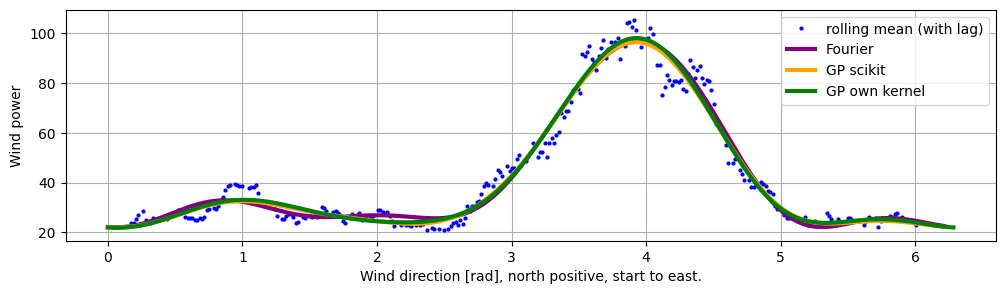

In [7]:
# Quick check
_, ax = plt.subplots(1,1, figsize=(12,3))
# ax.plot(df.index, df.wspd, linestyle='none', marker='o', markersize=2, color='red', label='Weatherstation')
ax.plot(df.index, df.wspd_rolling_mean, linestyle='none', marker='o', markersize=2, color='blue', label='rolling mean (with lag)')
ax.plot(df.index, s, linestyle='-', marker='none', markersize=2, color='purple', linewidth=3, label='Fourier')
ax.plot(df_gp.index, df_gp['wind'], linestyle='-', marker='none', markersize=2, color='orange', linewidth=3, label='GP scikit')
ax.plot(angles_eval, s_eval_gp, linestyle='-', marker='none', markersize=2, color='green', linewidth=3, label='GP own kernel')
ax.set_ylabel('Wind power')
ax.set_xlabel('Wind direction [rad], north positive, start to east.')
ax.legend()
ax.grid()

C:\Users\HenkColleenNiamh\AppData\Local\Temp\ipykernel_3744\3603340009.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'))


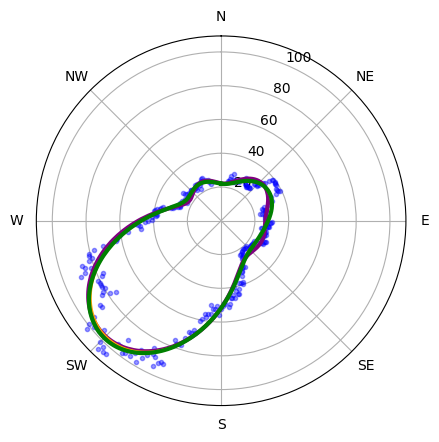

In [8]:
ax = plt.subplot(projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticklabels(('N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'))

ax.plot(df.index, df.wspd_rolling_mean, linestyle='none', marker='.', linewidth=3, color='blue', alpha=0.4)
ax.plot(df.index, s, linestyle='-', marker='none', linewidth=3, color='purple')
ax.plot(df_gp.index, df_gp.wind, linestyle='-', marker='none', linewidth=1, color='orange');
ax.plot(angles_eval, s_eval_gp, linestyle='-', marker='none', markersize=2, color='green', linewidth=3, label='GP own kernel');


### Conclusions
For the smooth 1D curve at hand, all methods (GP, GP skikit, Fourrier, Moving average) perform well. All method are largely dependent on hyper parameters. Probably the Fourrier series have the easiest parameters to set.

The periodic kernel does well in connecting the last and the first point.

So in the end its the old noise/bandwidth tradeoff.